In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/path/to/Utilities')

from Utilities.models_2_0 import *
import matplotlib.pyplot as plt

In [2]:
excel_filename = 'Eurofer/Eurofer_data_1_2.xlsx'
material_property = "Ultimate Strength_SH"
var_names, variables, dataframe = load_data(excel_filename, material_property, header_rows_list=[1, 3], num_data_rows=20, display_data_table_bool=False)

X0 = np.concatenate(variables[::2])
y0 = np.concatenate(variables[1::2])

print(X0.shape)
print(y0.shape)

(166,)
(166,)


In [3]:
material_property1 = "Yield Strength_SH"
var_names, variables, dataframe = load_data(excel_filename, material_property1, header_rows_list=[1, 3], num_data_rows=20, display_data_table_bool=False)

X1 = np.concatenate(variables[::2])
y1 = np.concatenate(variables[1::2])
print(X1.shape)
print(y1.shape)

(191,)
(191,)


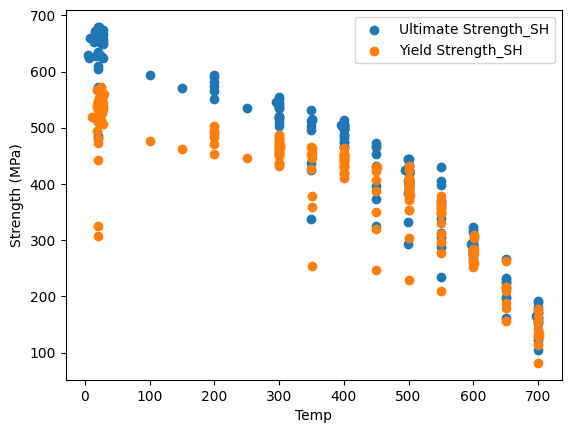

In [53]:
plt.scatter(X0, y0, label = material_property)
plt.scatter(X1, y1, label = material_property1)
plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

### General NN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [16]:
X = torch.tensor(X0, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y0, dtype=torch.float32).unsqueeze(1)

In [17]:
dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
learning_rate = 4e-3
weight_decay = 1e-5
model = Model(input_size = 1, hidden_size = 16, output_size = 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [25]:
epochs = 3000
Losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    if (epoch + 1) % 100 == 0:
        Losses.append(total_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')

Epoch [100/3000], Loss: 113976.0734
Epoch [200/3000], Loss: 103464.1719
Epoch [300/3000], Loss: 61613.8879
Epoch [400/3000], Loss: 3737.0967
Epoch [500/3000], Loss: 2421.9305
Epoch [600/3000], Loss: 4386.2365
Epoch [700/3000], Loss: 3266.1273
Epoch [800/3000], Loss: 2886.5328
Epoch [900/3000], Loss: 3689.3531
Epoch [1000/3000], Loss: 3042.9373
Epoch [1100/3000], Loss: 3363.2924
Epoch [1200/3000], Loss: 4227.8377
Epoch [1300/3000], Loss: 2908.3884
Epoch [1400/3000], Loss: 2718.8829
Epoch [1500/3000], Loss: 2923.4776
Epoch [1600/3000], Loss: 3515.7115
Epoch [1700/3000], Loss: 3139.1175
Epoch [1800/3000], Loss: 5448.5003
Epoch [1900/3000], Loss: 6453.4273
Epoch [2000/3000], Loss: 4285.4295
Epoch [2100/3000], Loss: 1274.9030
Epoch [2200/3000], Loss: 2597.4091
Epoch [2300/3000], Loss: 1108.6538
Epoch [2400/3000], Loss: 1312.9260
Epoch [2500/3000], Loss: 1984.2119
Epoch [2600/3000], Loss: 2368.6185
Epoch [2700/3000], Loss: 1416.8279
Epoch [2800/3000], Loss: 2114.7000
Epoch [2900/3000], Loss:

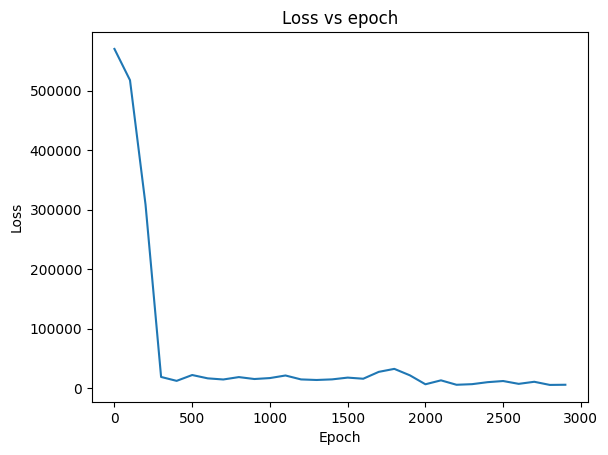

In [26]:
plt.plot(np.arange(len(Losses)) * 100, Losses)
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [27]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Test Loss: 3369.7142


In [28]:
X_test = np.arange(1,701)
y_test = []
model.eval()
for i in X_test:
    with torch.no_grad():
        predictions = model(torch.tensor([float(i)]))
        y_test.append(predictions.detach().numpy()[0])

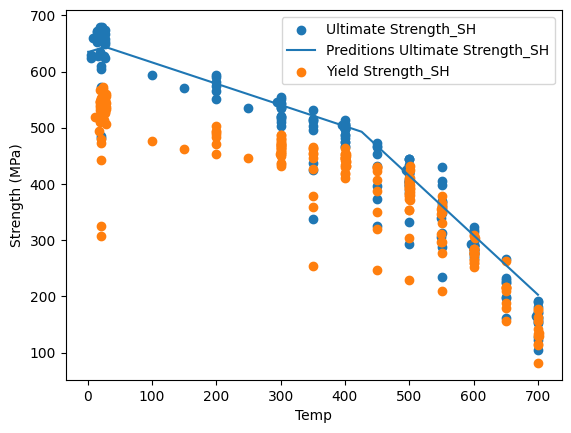

In [29]:
plt.scatter(X0, y0, label = material_property)
plt.plot(X_test, y_test, label = f"Preditions {material_property}" )
plt.scatter(X1, y1, label = material_property1)

plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

### K-Fold Cross Validation

In [30]:
from sklearn.model_selection import KFold


dataset = TensorDataset(X, y)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [38]:
model = Model(input_size=1, hidden_size=16, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
TrainLoss = []
ValLoss = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_val_loss = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        # Prepare data for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Training phase
        fold_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            fold_train_loss += loss.item()
        total_train_loss += fold_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        fold_val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                fold_val_loss += loss.item()
        total_val_loss += fold_val_loss / len(val_loader)

    # Print average training and validation loss across all folds every 100 epochs
    if (epoch + 1) % 100 == 0:
        avg_train_loss = total_train_loss / num_folds
        avg_val_loss = total_val_loss / num_folds
        print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
    if (epoch + 1) % 10 == 0:
        TrainLoss.append(total_train_loss / num_folds)
        ValLoss.append(total_val_loss / num_folds)

Epoch [100/3000] - Train Loss: 3094.8806, Val Loss: 12035.1451
Epoch [200/3000] - Train Loss: 3508.3696, Val Loss: 4249.3537
Epoch [300/3000] - Train Loss: 5186.2938, Val Loss: 8792.6802
Epoch [400/3000] - Train Loss: 1846.2158, Val Loss: 4115.4541
Epoch [500/3000] - Train Loss: 3372.8889, Val Loss: 6457.2396
Epoch [600/3000] - Train Loss: 2322.2570, Val Loss: 3589.1186
Epoch [700/3000] - Train Loss: 1859.6714, Val Loss: 2982.5299
Epoch [800/3000] - Train Loss: 2318.5381, Val Loss: 3954.5216
Epoch [900/3000] - Train Loss: 2217.8662, Val Loss: 2552.7708
Epoch [1000/3000] - Train Loss: 1726.4534, Val Loss: 3666.6384
Epoch [1100/3000] - Train Loss: 1406.4638, Val Loss: 2631.8493
Epoch [1200/3000] - Train Loss: 2672.0312, Val Loss: 4809.4703
Epoch [1300/3000] - Train Loss: 2383.6312, Val Loss: 4109.5430
Epoch [1400/3000] - Train Loss: 1622.7363, Val Loss: 2752.4191
Epoch [1500/3000] - Train Loss: 1652.8623, Val Loss: 2767.3706
Epoch [1600/3000] - Train Loss: 1812.3735, Val Loss: 2595.4603


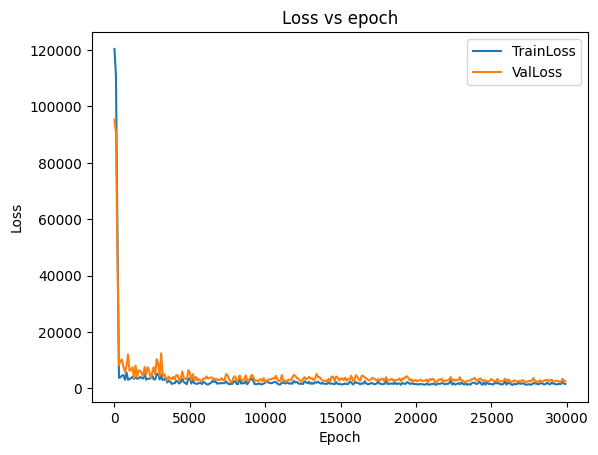

In [51]:
plt.plot(np.arange(len(TrainLoss)) * 100, TrainLoss, label = "TrainLoss")
plt.plot(np.arange(len(ValLoss)) * 100, ValLoss, label = "ValLoss")
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.xlim(500,3000)
plt.legend()
plt.show()

In [40]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Test Loss: 2537.8744


In [41]:
model.eval()
train_loss = 0
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        train_loss += loss.item()

print(f'Train Loss: {train_loss / len(train_loader):.4f}')

Train Loss: 1281.4267


In [47]:
X_test = np.arange(1,701)
y_test = []
model.eval()
for i in X_test:
    with torch.no_grad():
        predictions = model(torch.tensor([float(i)]))
        y_test.append(predictions.detach().numpy()[0])

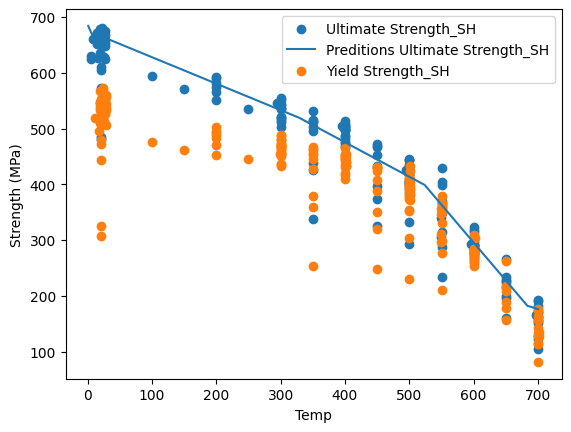

In [48]:
plt.scatter(X0, y0, label = material_property)
plt.plot(X_test, y_test, label = f"Preditions {material_property}" )
plt.scatter(X1, y1, label = material_property1)
plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

# Neural Network Improvement Strategies

## 1. **Data Augmentation**
- Helps prevent overfitting and improves model generalization.

## 2. **Feature Engineering / More Descriptors**
- Extract meaningful features from raw data to improve the model’s ability to learn.
- Example: Add domain-specific descriptors or combine existing features in new ways.

## 3. **Data Normalization**
- Improves convergence speed and prevents numerical instability.

## 4. **Hyperparameter Tuning**
- Optimize key parameters such as:
  - Learning rate
  - Number of hidden layers and neurons
  - Batch size
- Grid Search, Random Search, or Bayesian Optimization

## 5. **Evaluation Metrics**
  - RMSE
  - Accuracy
  - Precision/Recall
  - F1 Score
  - Mean Absolute Error (MAE)

## 6. **Experiment with Optimizers**
  - Adam
  - SGD with momentum
  - RMSProp
  - AdamW

## 7. **Regularization**
- Reduce overfitting using:
  - Dropout
  - L2 regularization
  - Early stopping based on validation loss

## 8. **More Complex Neural Network Architectures**
- Experiment with advanced architectures such as:
  - Adding more layers and neurons (Deep Neural Networks)
  - Attention mechanisms for focusing on relevant parts of data
  - Transformers

## 9. **Ensemble Learning**
- Combine predictions from multiple models to improve robustness:
  - Averaging
  - Bagging or boosting techniques

